# MSE and CrossEntropy comprasion

In [1]:
import peptides
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
from collections import Counter

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from scipy.stats import entropy
#from umap import UMAP

# my module with some func
import pepcode
from tg_bot_notification import telegram_logger

## Set Parameters:

In [2]:
start_time = datetime.datetime.now()
AA_LIST = pepcode.AA_LIST

latent_dims = 32
num_epochs = 200
batch_size = 400
learning_rate = 1e-4 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

sns.set_theme(style="darkgrid")
default_color = "xkcd:dark pastel green"

## Preparing data

In [3]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)

# Filter cdr3 with 10<len<20 and stars with 'C' and ends with 'F' or 'W'
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)>10 and len(data.iloc[i].cdr3)<20 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

# Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list_ori = data_train.cdr3.values
pep_test_list_ori = data_test.cdr3.values
pep_eval_list_ori = data_eval.cdr3.values

# Gap insertion
pep_train_list = []
for seq in pep_train_list_ori:
    gap_count = 19-len(seq) # max_len = 19
    pep_train_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_train_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_train_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_train_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])
    
pep_test_list = []
for seq in pep_test_list_ori:
    gap_count = 19-len(seq) # max_len = 19
    pep_test_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_test_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_test_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_test_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])

pep_eval_list = []
for seq in pep_eval_list_ori:
    gap_count = 19-len(seq) # max_len = 19
    pep_eval_list.append(seq[0:3]+'-'*gap_count+seq[3:])
    pep_eval_list.append(seq[0:4]+'-'*gap_count+seq[4:])
    pep_eval_list.append(seq[0:-3]+'-'*gap_count+seq[-3:])
    pep_eval_list.append(seq[0:-4]+'-'*gap_count+seq[-4:])


len_seq = len(pep_train_list[0])


pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])  

pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  



oh_matr_size = pep_test_oh[0].size


# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_train_dl = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_test_dl = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)

/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Autoencoder class definition

In [4]:
autoencoder_arch = f'{oh_matr_size}->{latent_dims}'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=len(AA_LIST)*len_seq),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded

## Autoencoder definition (MSELoss)

In [5]:
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Train autoencoder (MSELoss)

In [6]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:
        
        pep_batch = pep_batch.to(device)
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        pep_batch_recon = autoencoder(pep_batch)

        loss = loss_function(pep_batch_recon, pep_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    if epoch % 50 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 0.178157
Epoch [51 / 200] average reconstruction error: 0.006843
Epoch [101 / 200] average reconstruction error: 0.005221
Epoch [151 / 200] average reconstruction error: 0.004703
Train finished


### Evaluation on test set (MSELoss)

In [7]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches

print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'entropy', entropy_threshold = 2.5))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'entropy', entropy_threshold = 2.5))

Average reconstruction error: 0.004572


### Biological evaluatiuon (MSELoss)

In [8]:
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}

# Gaps distribution
for i in range(len(pep_test_list_bef_ae)):
    for j in range(0, len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        #Gaps count
        if aa_before == '-':
            gap_dict_before[j] += 1
        if aa_after == '-':
            gap_dict_after[j] += 1


# Remove gaps from sequence and choose the hight freq. variant
pep_test_list_bef_no_gap = []
pep_test_list_aft_no_gap = []
for i in range(0, len(pep_test_list_bef_ae), 4):
    pep_test_list_bef_no_gap.append(pep_test_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_test_list_aft_ae[i].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_test_list_aft_no_gap.append(c.most_common(1)[0][0])


# Compare lenght of sequence after reconstruction
new_seq_lens_dict = {}
for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'-{len_after}') in new_seq_lens_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1
new_seq_lens_dict = dict(sorted(new_seq_lens_dict.items(), key=lambda item: item[1]))



err_seq_dict = {}
err_count_no_gap = {key/100.0: 0 for key in range(0, 100, 5)}
pos_lst = np.asarray(list(err_count_no_gap.keys()))
#err_count_no_gap = np.zeros(len_seq, dtype = np.float32)
err_dict_no_gap = {}
counter = 0

pep_test_list_bef_ae_no_gap_aa = []
pep_test_list_aft_ae_no_gap_aa = []


for i in range(len(pep_test_list_bef_no_gap)):
    seq_before = pep_test_list_bef_no_gap[i]
    seq_after = pep_test_list_aft_no_gap[i]
    
    # Save sequences with different lenght
    if len(seq_after) != len(seq_before):
        err_seq_dict[seq_before] = seq_after
        continue
        
    # Save number of right lenght sequences
    counter += 1

    # Compare the right lenght sequences
    for j in range(len(seq_before)):
        aa_before = seq_before[j]
        aa_after = seq_after[j]

        
        if aa_before != aa_after:
            err_rel_pos = round(j/len(seq_before),2)
            idx = (np.abs(pos_lst - err_rel_pos)).argmin()
            target_pos = pos_lst[idx]
            err_count_no_gap[target_pos] += 1 
            
            if aa_before+aa_after in err_dict_no_gap.keys():
                err_dict_no_gap[aa_before+aa_after] += 1
            else:
                err_dict_no_gap[aa_before+aa_after] = 1
        # For classification report only
        pep_test_list_bef_ae_no_gap_aa.append(aa_before)
        pep_test_list_aft_ae_no_gap_aa.append(aa_after)
                
err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))



errors_freq = 10 #by quantity
err_dict_hf = {}
for i in err_dict_no_gap.keys():
    if err_dict_no_gap[i] > errors_freq:
        err_dict_hf[i] = err_dict_no_gap[i]

err_count_no_gap_1=err_count_no_gap

print(f'From {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}. Different lenghts: {new_seq_lens_dict}')

From 7057 sequences with right seq len:6905. Different lenghts: {'15-16': 1, '18-19': 1, '13-12': 1, '11-12': 1, '12-11': 1, '16-17': 2, '17-18': 2, '14-13': 8, '19-18': 17, '18-17': 23, '15-14': 24, '16-15': 34, '17-16': 37}


#### Gap distribution (MSELoss)

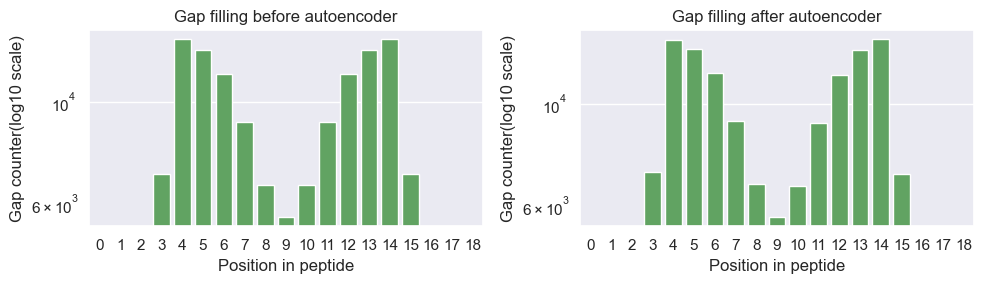

In [9]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = default_color, ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = default_color, ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Main report (MSELoss)

In [11]:
# fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

# sns.pointplot(train_loss_avg , color = default_color, ax=axs[0, 0])
# sns.barplot(dict(list(err_dict_no_gap.items())[-5:]), color = default_color, ax=axs[1, 0])
# sns.pointplot(err_count_no_gap , color = default_color, ax=axs[2, 0])
# sns.pointplot(err_count_no_gap/counter*100 , color = default_color, ax=axs[2, 1])

# axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSELoss')
# axs[0, 0].legend()
# axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n', xticks=[i for i in range(1, num_epochs, int(num_epochs/5))])
# axs[0, 1].set(frame_on=False)
# axs[0, 1].set_xticks([])
# axs[0, 1].set_yticks([])
# axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSELoss: {round(test_loss_avg_1, 5)}\n\nFrom {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}\n\n{classification_report(pep_test_list_bef_ae_no_gap_aa, pep_test_list_aft_ae_no_gap_aa)}')
# axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminoacid change', title=f'Aminoacid changes (5 most common)')
# axs[1, 1].set(frame_on=False)
# axs[1, 1].set_xticks([])
# axs[1, 1].set_yticks([])
# axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position')
# axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position (in %)', yticks=[i*10 for i in range(1, 10)])
# axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])
# axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])


# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# fig.suptitle(f'One-hot encoder with arch {autoencoder_arch} on test set') 
# plt.show()
# #fig.savefig(f'./Results_one_hot/{str(date.today())}_{autoencoder_arch}_on_test_MSELoss.pdf', format='pdf')


## Autoencoder definition (CELoss)

In [12]:
#latent_dims = len(AA_LIST)

autoencoder_arch = f'{oh_matr_size}->{latent_dims}'

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=latent_dims)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=len(AA_LIST)*len_seq),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encoding(self, x):
        encoded = self.encoder(x)
        return encoded

    def decoding(self, encoded):
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = learning_rate)

### Train autoencoder (CELoss)

In [13]:
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_train_dl:

        
        pep_batch = pep_batch.to(device)
        pep_batch_o = pep_batch # Save origin matrix before reshaping
        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder(pep_batch)
        pep_batch_recon_rsh = pep_batch_recon.reshape(pep_batch_o.shape) # Reshape to original
        #pep_batch_recon_rsh_sfm = pep_batch_recon_rsh.softmax(dim=1) # Normalization
        # reconstruction error
        #loss = loss_function(pep_batch_recon_rsh_sfm, pep_batch_o)
        loss = loss_function(pep_batch_recon_rsh, pep_batch_o)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    
    train_loss_avg[-1] /= num_batches
    
    if epoch % 40 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
print('Train finished')

Training ...
Epoch [1 / 200] average reconstruction error: 2.637241
Epoch [41 / 200] average reconstruction error: 0.259539
Epoch [81 / 200] average reconstruction error: 0.179758
Epoch [121 / 200] average reconstruction error: 0.146045
Epoch [161 / 200] average reconstruction error: 0.123390
Train finished


### Evaluation on test set (CELoss)

In [14]:
autoencoder.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_test_dl:
    with torch.no_grad():
        pep_o = pep
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_o = pep_o.to(device)
        pep_recon = autoencoder(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches

print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i], mode = 'argmax'))  
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i], mode = 'argmax'))

Average reconstruction error: 0.118223


### Biological evaluation (CELoss)

In [15]:
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}

# Gaps distribution
for i in range(len(pep_test_list_bef_ae)):
    for j in range(0, len_seq):
        aa_before = pep_test_list_bef_ae[i][j]
        aa_after = pep_test_list_aft_ae[i][j]
        #Gaps count
        if aa_before == '-':
            gap_dict_before[j] += 1
        if aa_after == '-':
            gap_dict_after[j] += 1


# Remove gaps from sequence and choose the hight freq. variant
pep_test_list_bef_no_gap = []
pep_test_list_aft_no_gap = []
for i in range(0, len(pep_test_list_bef_ae), 4):
    pep_test_list_bef_no_gap.append(pep_test_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_test_list_aft_ae[i].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_test_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_test_list_aft_no_gap.append(c.most_common(1)[0][0])


# Compare lenght of sequence after reconstruction
new_seq_lens_dict = {}
for i in range(len(pep_test_list_bef_no_gap)):
    len_before = len(pep_test_list_bef_no_gap[i])
    len_after = len(pep_test_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'-{len_after}') in new_seq_lens_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1
new_seq_lens_dict = dict(sorted(new_seq_lens_dict.items(), key=lambda item: item[1]))



err_seq_dict = {}
err_count_no_gap = {key/100.0: 0 for key in range(0, 100, 5)}
pos_lst = np.asarray(list(err_count_no_gap.keys()))
#err_count_no_gap = np.zeros(len_seq, dtype = np.float32)
err_dict_no_gap = {}
counter = 0

pep_test_list_bef_ae_no_gap_aa = []
pep_test_list_aft_ae_no_gap_aa = []


for i in range(len(pep_test_list_bef_no_gap)):
    seq_before = pep_test_list_bef_no_gap[i]
    seq_after = pep_test_list_aft_no_gap[i]
    
    # Save sequences with different lenght
    if len(seq_after) != len(seq_before):
        err_seq_dict[seq_before] = seq_after
        continue
        
    # Save number of right lenght sequences
    counter += 1

    # Compare the right lenght sequences
    for j in range(len(seq_before)):
        aa_before = seq_before[j]
        aa_after = seq_after[j]

        
        if aa_before != aa_after:
            err_rel_pos = round(j/len(seq_before),2)
            idx = (np.abs(pos_lst - err_rel_pos)).argmin()
            target_pos = pos_lst[idx]
            err_count_no_gap[target_pos] += 1 
            
            if aa_before+aa_after in err_dict_no_gap.keys():
                err_dict_no_gap[aa_before+aa_after] += 1
            else:
                err_dict_no_gap[aa_before+aa_after] = 1
        # For classification report only
        pep_test_list_bef_ae_no_gap_aa.append(aa_before)
        pep_test_list_aft_ae_no_gap_aa.append(aa_after)
                
err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))



errors_freq = 10 #by quantity
err_dict_hf = {}
for i in err_dict_no_gap.keys():
    if err_dict_no_gap[i] > errors_freq:
        err_dict_hf[i] = err_dict_no_gap[i]


print(f'From {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}. Different lenghts: {new_seq_lens_dict}')

From 7057 sequences with right seq len:7019. Different lenghts: {'15-14': 1, '13-12': 1, '14-13': 1, '12-13': 1, '17-16': 2, '15-16': 2, '19-18': 3, '16-17': 3, '11-12': 3, '17-18': 5, '16-15': 8, '18-17': 8}


#### Gap distribution (CELoss)

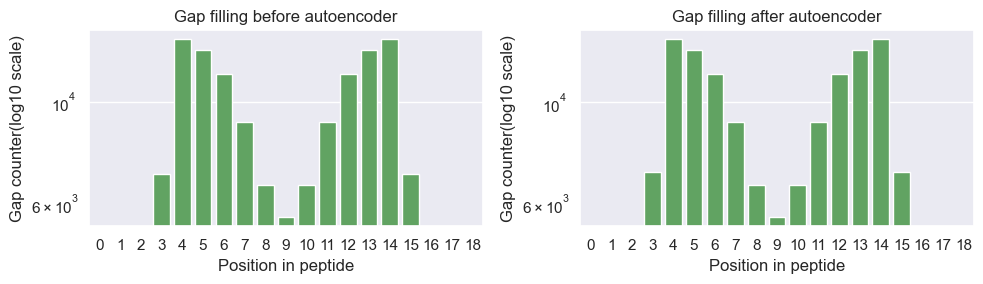

In [16]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = default_color, ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = default_color, ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Main report (CELoss)

In [17]:
# fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

# sns.pointplot(train_loss_avg , color = default_color, ax=axs[0, 0])
# sns.barplot(dict(list(err_dict_no_gap.items())[-5:]), color = default_color, ax=axs[1, 0])
# sns.pointplot(err_count_no_gap , color = default_color, ax=axs[2, 0])
# sns.pointplot(err_count_no_gap/counter*100 , color = default_color, ax=axs[2, 1])

# axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test CELoss')
# axs[0, 0].legend()
# axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n', xticks=[i for i in range(1, num_epochs, int(num_epochs/5))])
# axs[0, 1].set(frame_on=False)
# axs[0, 1].set_xticks([])
# axs[0, 1].set_yticks([])
# axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nCELoss: {round(test_loss_avg_1, 5)}\n\nFrom {len(pep_test_list_bef_no_gap)} sequences with right seq len:{counter}\n\n{classification_report(pep_test_list_bef_ae_no_gap_aa, pep_test_list_aft_ae_no_gap_aa)}')
# axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminoacid change', title=f'Aminoacid changes (5 most common)')
# axs[1, 1].set(frame_on=False)
# axs[1, 1].set_xticks([])
# axs[1, 1].set_yticks([])
# axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position')
# axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position (in %)', yticks=[i*10 for i in range(1, 10)])
# axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])
# axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])


# plt.subplots_adjust(wspace=0.2, hspace=0.5)
# fig.suptitle(f'One-hot encoder with arch {autoencoder_arch} on test set') 
# plt.show()
# #fig.savefig(f'./Results_one_hot/{str(date.today())}_{autoencoder_arch}_on_test_CELoss.pdf', format='pdf')


In [18]:
chat_id = 195865048
@telegram_logger(chat_id)
def end_of_notebook(start_time):
    return (datetime.datetime.now() - start_time)

end_of_notebook(start_time)

## Evaluation on evaluation dataset (CELoss)

In [17]:
autoencoder.eval()

output = []
eval_loss_avg_1, num_batches = 0, 0

for (pep, _) in oh_eval_dl:
    with torch.no_grad():
        pep_o = pep
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_o = pep_o.to(device)
        pep_recon = autoencoder(pep)
        pep_recon_rs = pep_recon.reshape(pep_o.shape)
        loss = loss_function(pep_recon_rs, pep_o)
        eval_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
eval_loss_avg_1 /= num_batches

print('Average reconstruction error: %f' % (eval_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_eval_oh_bef = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_eval_oh_aft = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_eval_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_eval_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    
pep_eval_list_bef_ae = []
pep_eval_list_aft_ae = []

for i in range(pep_eval_oh_aft.shape[0]):
    pep_eval_list_bef_ae.append(pepcode.one_hot_decode(pep_eval_oh_bef[i], mode = 'argmax'))  
    pep_eval_list_aft_ae.append(pepcode.one_hot_decode(pep_eval_oh_aft[i], mode = 'argmax'))

Average reconstruction error: 0.012555


### Biological evaluatiuon (CELoss)

In [18]:
gap_dict_before = {key: 0 for key in range(len_seq)}
gap_dict_after = {key: 0 for key in range(len_seq)}

# Gaps distribution
for i in range(len(pep_eval_list_bef_ae)):
    for j in range(0, len_seq):
        aa_before = pep_eval_list_bef_ae[i][j]
        aa_after = pep_eval_list_aft_ae[i][j]
        #Gaps count
        if aa_before == '-':
            gap_dict_before[j] += 1
        if aa_after == '-':
            gap_dict_after[j] += 1


# Remove gaps from sequence and choose the hight freq. variant
pep_eval_list_bef_no_gap = []
pep_eval_list_aft_no_gap = []
for i in range(0, len(pep_eval_list_bef_ae), 4):
    pep_eval_list_bef_no_gap.append(pep_eval_list_bef_ae[i].replace('-', ''))
    var = []
    var.append(pep_eval_list_aft_ae[i].replace('-', ''))
    var.append(pep_eval_list_aft_ae[i+1].replace('-', ''))
    var.append(pep_eval_list_aft_ae[i+2].replace('-', ''))
    var.append(pep_eval_list_aft_ae[i+3].replace('-', ''))
    c = Counter(var)
    pep_eval_list_aft_no_gap.append(c.most_common(1)[0][0])


# Compare lenght of sequence after reconstruction
new_seq_lens_dict = {}
for i in range(len(pep_eval_list_bef_no_gap)):
    len_before = len(pep_eval_list_bef_no_gap[i])
    len_after = len(pep_eval_list_aft_no_gap[i])
    if len_before != len_after:
        if (f'{len_before}'+f'-{len_after}') in new_seq_lens_dict.keys():
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] += 1
        else:
            new_seq_lens_dict[f'{len_before}'+f'-{len_after}'] = 1
new_seq_lens_dict = dict(sorted(new_seq_lens_dict.items(), key=lambda item: item[1]))



err_seq_dict = {}
err_count_no_gap = np.zeros(len_seq, dtype = np.float32)
err_dict_no_gap = {}
counter = 0

pep_eval_list_bef_ae_no_gap_aa = []
pep_eval_list_aft_ae_no_gap_aa = []


for i in range(len(pep_eval_list_bef_no_gap)):
    seq_before = pep_eval_list_bef_no_gap[i]
    seq_after = pep_eval_list_aft_no_gap[i]
    
    # Save sequences with different lenght
    if len(seq_after) != len(seq_before):
        err_seq_dict[seq_before] = seq_after
        continue
        
    # Save number of right lenght sequences
    counter += 1

    # Compare the right lenght sequences
    for j in range(len(seq_before)):
        aa_before = seq_before[j]
        aa_after = seq_after[j]

        
        if aa_before != aa_after:
            err_count_no_gap[j] +=1
            if aa_before+aa_after in err_dict_no_gap.keys():
                err_dict_no_gap[aa_before+aa_after] += 1
            else:
                err_dict_no_gap[aa_before+aa_after] = 1
        # For classification report only
        pep_eval_list_bef_ae_no_gap_aa.append(aa_before)
        pep_eval_list_aft_ae_no_gap_aa.append(aa_after)
                
err_dict_no_gap = dict(sorted(err_dict_no_gap.items(), key=lambda item: item[1]))



errors_freq = 10 #by quantity
err_dict_hf = {}
for i in err_dict_no_gap.keys():
    if err_dict_no_gap[i] > errors_freq:
        err_dict_hf[i] = err_dict_no_gap[i]


print(f'From {len(pep_eval_list_bef_no_gap)} sequences with right seq len:{counter}. Different lenghts: {new_seq_lens_dict}')

From 7058 sequences with right seq len:7053. Different lenghts: {'14-13': 1, '19-18': 1, '18-19': 3}


#### Gap distribution

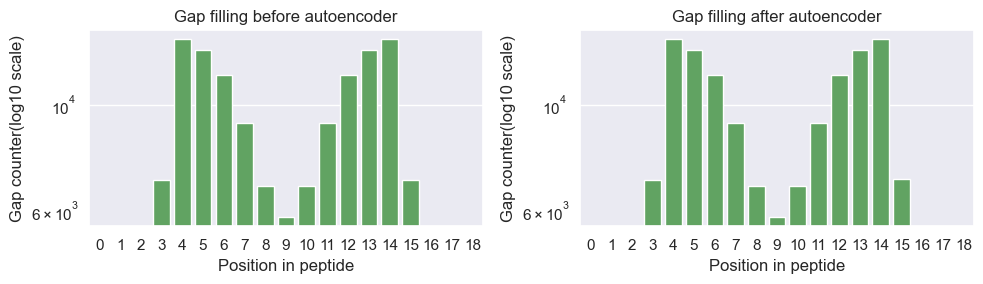

In [19]:
fig, axs = plt.subplots(1, 2,  figsize = [10, 3])
sns.barplot(gap_dict_before, color = default_color, ax=axs[0])
axs[0].set_yscale("log")
sns.barplot(gap_dict_after, color = default_color, ax=axs[1])
axs[1].set_yscale("log")
axs[0].set(title='Gap filling before autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
axs[1].set(title='Gap filling after autoencoder', xlabel='Position in peptide', ylabel='Gap counter(log10 scale)')
plt.tight_layout()
plt.show()

#### Main report

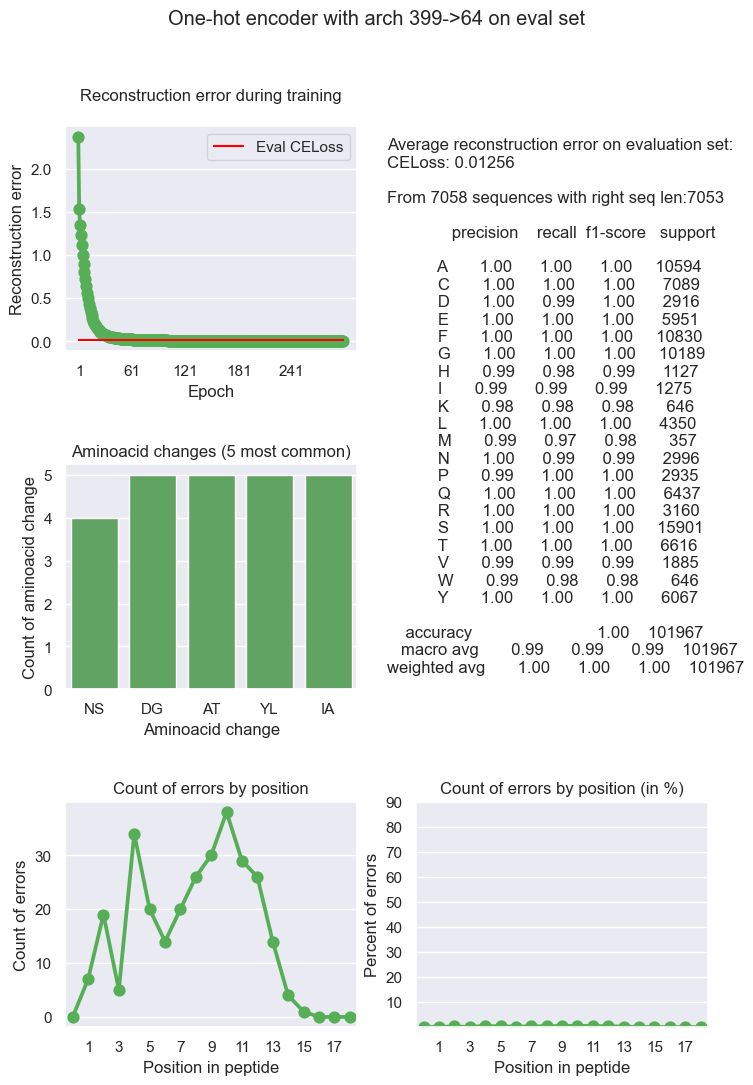

In [20]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg , color = default_color, ax=axs[0, 0])
sns.barplot(dict(list(err_dict_no_gap.items())[-5:]), color = default_color, ax=axs[1, 0])
sns.pointplot(err_count_no_gap , color = default_color, ax=axs[2, 0])
sns.pointplot(err_count_no_gap/counter*100 , color = default_color, ax=axs[2, 1])

axs[0, 0].hlines(round(eval_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Eval CELoss')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n', xticks=[i for i in range(1, num_epochs, int(num_epochs/5))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on evaluation set:\nCELoss: {round(eval_loss_avg_1, 5)}\n\nFrom {len(pep_eval_list_bef_no_gap)} sequences with right seq len:{counter}\n\n{classification_report(pep_eval_list_bef_ae_no_gap_aa, pep_eval_list_aft_ae_no_gap_aa)}')
axs[1, 0].set(xlabel='Aminoacid change', ylabel='Count of aminoacid change', title=f'Aminoacid changes (5 most common)')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position (in %)', yticks=[i*10 for i in range(1, 10)])
axs[2, 0].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])
axs[2, 1].set_xticks([i for i in range(1, len_seq, int(len_seq/9))])


plt.subplots_adjust(wspace=0.2, hspace=0.5)
fig.suptitle(f'One-hot encoder with arch {autoencoder_arch} on eval set') 
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{autoencoder_arch}_on_eval_CELoss.pdf', format='pdf')


## End of notebook

In [21]:
chat_id = 195865048
@telegram_logger(chat_id)
def end_of_notebook(start_time):
    return (datetime.datetime.now() - start_time)

end_of_notebook(start_time)

In [25]:
torch.save(autoencoder, f'One-hot_models/model_final.pth')

In [23]:
for key, val in err_count_no_gap.items():
    err_count_no_gap[key] = val/7063*100
for key, val in err_count_no_gap_1.items():
    err_count_no_gap_1[key] = val/7063*100

df1 = pd.DataFrame(list(err_count_no_gap.items()), columns=['x', 'y'])
df1['seq'] = 'CE_Loss'

df2 = pd.DataFrame(list(err_count_no_gap_1.items()), columns=['x', 'y'])
df2['seq'] = 'MSE_Loss'

# Объединяем DataFrame
df = pd.concat([df1, df2])


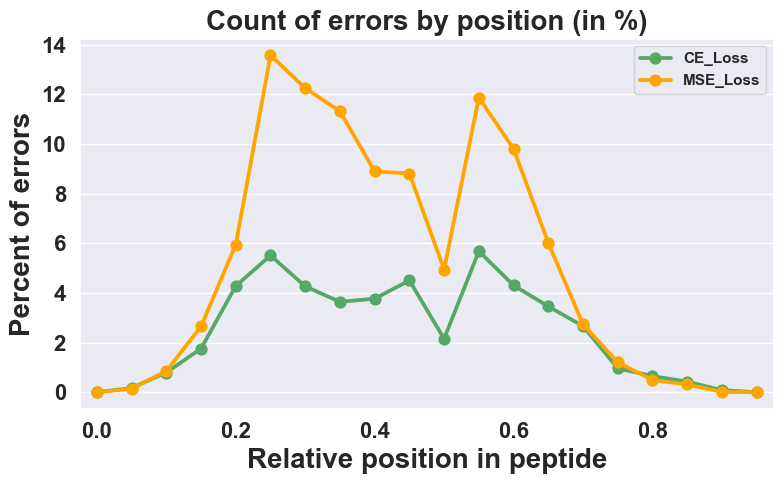

In [32]:
f = plt.figure(figsize=(8, 5))
a = sns.pointplot(x='x', y='y', hue='seq', data=df, palette=['g', '#FFA500'])
a.set_xlabel('Relative position in peptide', size=20, weight='bold')
a.set_ylabel('Percent of errors', size=20, weight='bold')
a.set_title(f'Count of errors by position (in %)', weight='bold',  size=20)
a.set_xticks([0, 4, 8, 12, 16])
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
#a.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.tight_layout()
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()
f.savefig('loss_final.png', format='png')